In [1]:
import tensorflow as tf
import os
import matplotlib.pyplot as plt
import numpy as np
import cv2
import zipfile
import shutil
import warnings
from typing import List
from typing import Tuple

warnings.filterwarnings('ignore')
plt.style.use('ggplot')

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, RandomFlip,RandomCrop

from tensorflow.keras.callbacks import ModelCheckpoint

from tensorflow.keras.models import load_model

seed = 42
tf.random.set_seed(seed)

2024-08-23 08:41:22.838594: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-08-23 08:41:23.163238: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-08-23 08:41:24.162001: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [3]:
# Avoid OOM errors by setting GPU Memory Consumption Growth when using GPU
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

In [6]:
from random import sample
def files_remover_from_dir(dir_path:str, size:int) -> None:
    files = os.listdir(dir_path)
    sample_list = sample(files, size)
    for file in sample_list:
        try:
            file_path = os.path.join(dir_path, file)
            os.remove(file_path)
        except:
            print('File Not Found')

In [11]:
path = '/teamspace/studios/this_studio/EFlow Images/AlexNet/imbalanced_data/background'
# size = int(len(os.listdir(path)) * 0.2)
# print(f'Existing number of Background Images: {len(os.listdir(path))}')
# print(f'Number of files that will be removed: {size}')

# try:
#     files_remover_from_dir(path,size)
# except:
#     print('Try Again')

# print(f'Number of remaining background images: {len(os.listdir(path))}')

In [12]:
model = load_model('/teamspace/studios/this_studio/EFlow Images/AlexNet/alex_netClassifier.keras')

Found 13610 files belonging to 2 classes.


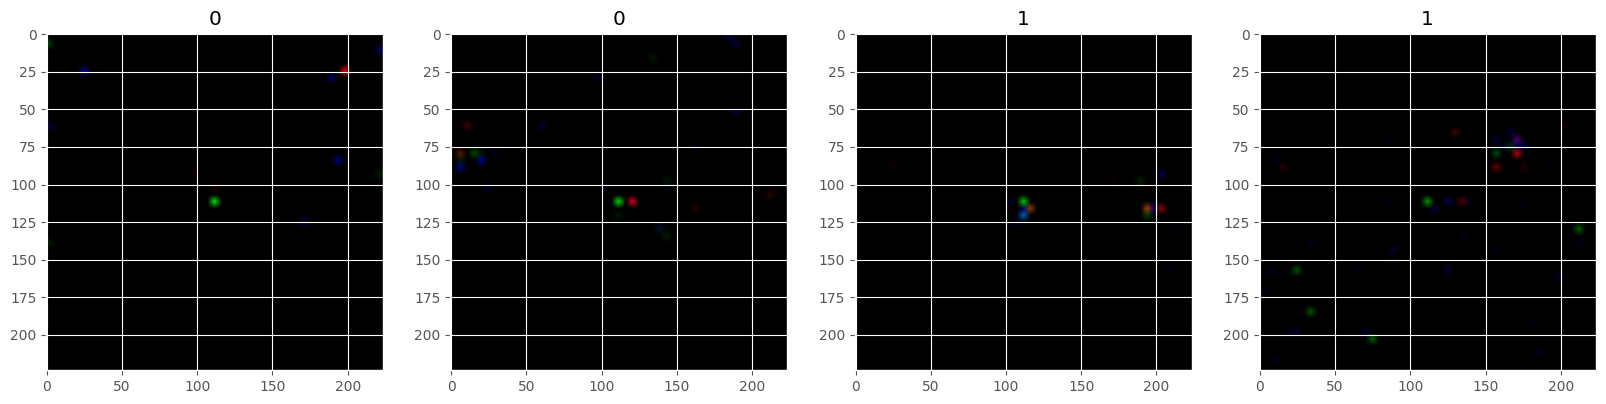

In [13]:
data_dir = '/teamspace/studios/this_studio/EFlow Images/AlexNet/imbalanced_data'

data = tf.keras.utils.image_dataset_from_directory(data_dir,
                                                   seed=seed,
                                                   batch_size = 70,
                                                   image_size = (224,224))

data = data.map(lambda x, y: (x/255, y))

data_iterator = data.as_numpy_iterator()

batch = data_iterator.next()

fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img)
    ax[idx].title.set_text(batch[1][idx])

# Extracting True Labels

In [14]:
data_list = list(data)
labels = []
for batch in data_list:
    images, label = batch
    # Process your batch here
    labels.append(label.numpy())
    #print(images.shape, labels.shape)
y_true = np.concatenate(labels, axis=0)

2024-08-22 05:43:11.355887: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [17]:
print(f'Number of Class 0(Background) Images: {len(y_true[y_true == 0])}')
print(f'Number of Class 1(Signal) Images: {len(y_true[y_true == 1])}')

Number of Class 0(Background) Images: 3782
Number of Class 1(Signal) Images: 9828


# Making Predictions on the Imbalanced Data

In [18]:
y_pred = model.predict(data)

I0000 00:00:1724305521.107517    3961 service.cc:145] XLA service 0x7f209c0092e0 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1724305521.110208    3961 service.cc:153]   StreamExecutor device (0): Host, Default Version
2024-08-22 05:45:21.260678: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1724305521.850647    3961 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


195/195 ━━━━━━━━━━━━━━━━━━━━ 114s 580ms/step


In [19]:
y_pred = y_pred.reshape((-1))

In [20]:
y_pred.shape

(13610,)

In [21]:
def roc(y_true:List, y_pred:List, thresholds:List) -> Tuple:
    FPR = []
    TPR = []
    P = sum(y_true) #Number of Positives labels
    N = len(y_true) - P #Number of Negative Labels

    for thresh in thresholds:
        FP = 0
        TP = 0
        thresh = round(thresh,2)
        for i in range(len(y_pred)):
            if (y_pred[i] >= thresh):
                if y_true[i] == 1:
                    TP += 1
                if y_true[i] == 0:
                    FP += 1
        FPR.append(FP/N)
        TPR.append(TP/P)
    AUC = -1 * np.trapz(TPR, FPR)

    return (FPR, TPR, AUC)

def plotROC_curve(FPR, TPR, AUC):
    plt.plot(FPR, TPR, linestyle='--', marker='o', color='darkorange', lw = 2, label='ROC curve', clip_on=False)
    plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC curve, AUC = %.2f'%AUC)
    plt.legend(loc="lower right")
    plt.show()

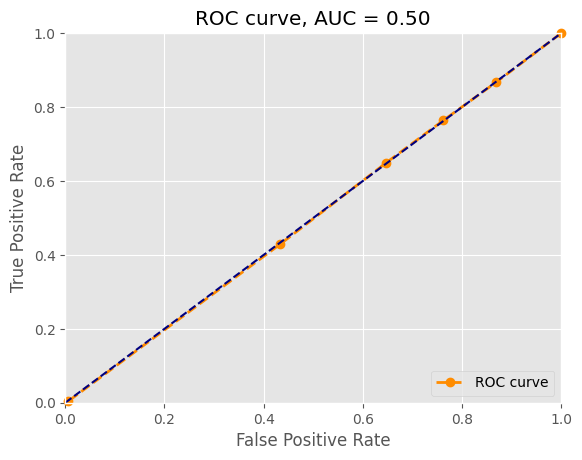

In [22]:
thresh = np.arange(0.0, 1.01, 0.2)
FPR, TPR, AUC = roc(y_true, y_pred, thresh)
plotROC_curve(FPR, TPR, AUC)

In [28]:
np.sum((y_true != y_pred).astype('int64'))

13575

In [29]:
data_label = np.concatenate([y for x, y in data], axis=0) 

2024-08-22 06:16:18.158226: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [30]:
data_label.shape

(13610,)

In [32]:
np.sum((data_label != y_pred).astype('int64'))

13572